# Project: ReID

## Introduction

We wanted to reidentify a person, given some samples of the dataset. The idea is to learn the main features of the person in order to distinguish him/her from other people.



The first thing that we did was to import libraries.

In [23]:
from sklearn.svm import SVC
from sklearn.svm import SVR

from load_data import DataLoader
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import tqdm
import config
import math
import matplotlib.pyplot as plt
import scikitplot as skplt
from utils import filter_and_split_dataset



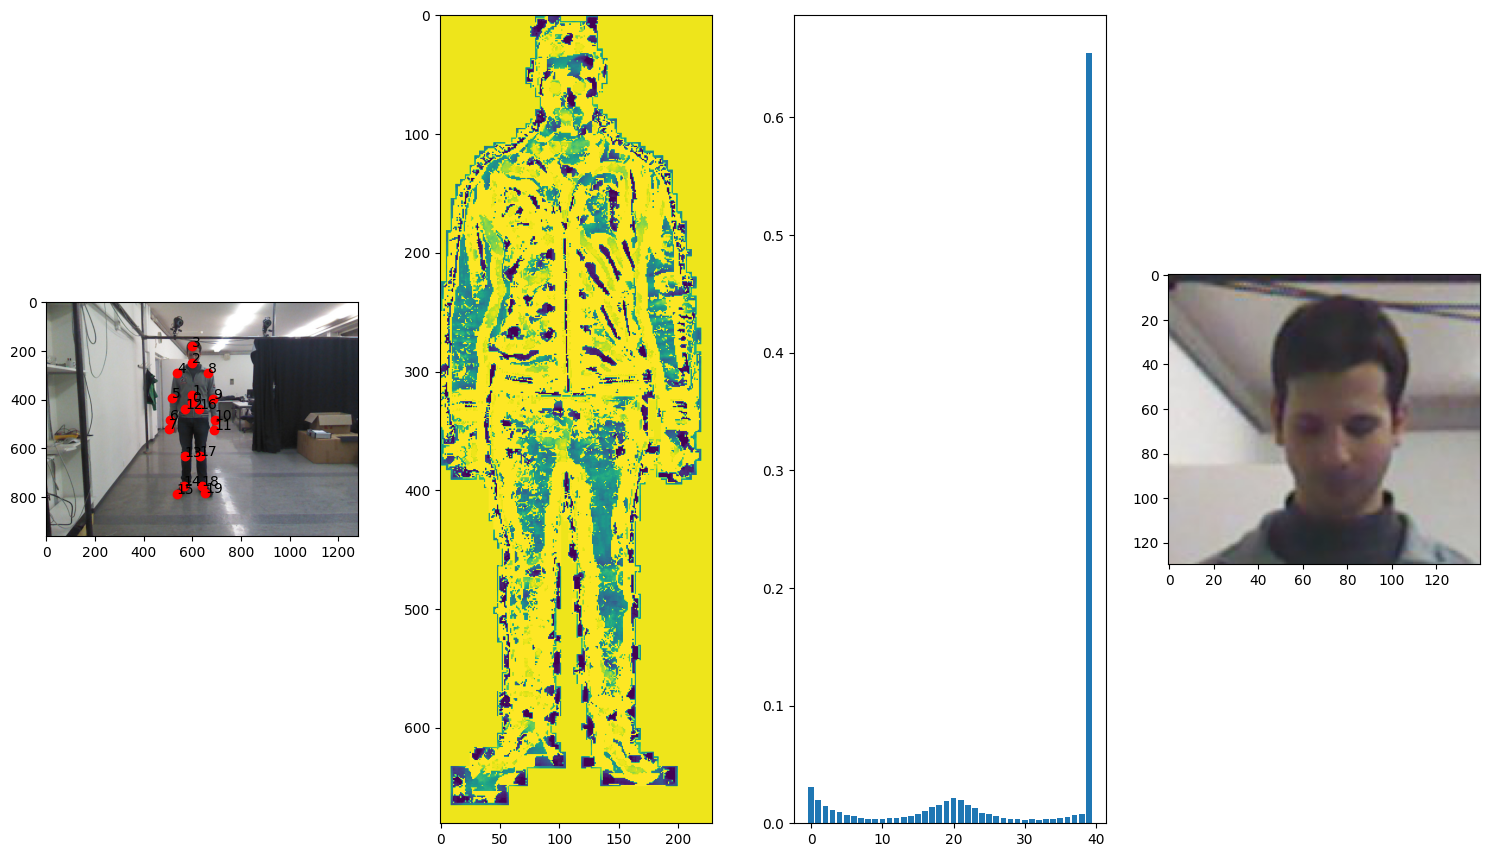

In [24]:
d = DataLoader()
d.read_dataset()
d.shuffle_videos()
d.display_dataset()

metrics = []


The next thing to do was to design the learning setting. The first and easiest idea was to test a variety of classifiers, and see which works better for our features.

We tested different classifiers:

In [25]:
def test_model(name, model_skel, model_clothes, model_face, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test):
    global metrics
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)


    print("-" * 10)
    print("|", name, "|")
    # Test
    print("-" * 10)
    skel_pred = model_skel.predict(X_skel_test)
    print(classification_report(y_test, skel_pred))
    print("-" * 10)
    clothes_pred = model_clothes.predict(X_clothes_test)
    print(classification_report(y_test, clothes_pred))
    print("-" * 10)
    face_pred = model_face.predict(X_face_test)
    print(classification_report(y_face_test, face_pred))

    skel_pred_roc = model_skel.predict_proba(X_skel_test)
    clothes_pred_roc = model_clothes.predict_proba(X_clothes_test)
    face_pred_roc = model_face.predict_proba(X_face_test)

    metrics.append([name.split("_")[-1].split(".")[-1], y_test, y_face_test, skel_pred, clothes_pred, face_pred, skel_pred_roc, clothes_pred_roc, face_pred_roc])


In [26]:
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy")
X_skel, X_clothes, X_face, _, ___, ____, y_train, _____, y_face, ______ = filter_and_split_dataset(X, y)

X_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y_2 = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy")
X_skel_test, X_clothes_test, X_face_test, _, __, ___, y_test, ____, y_face_test, _____ = filter_and_split_dataset(X_2, y_2)



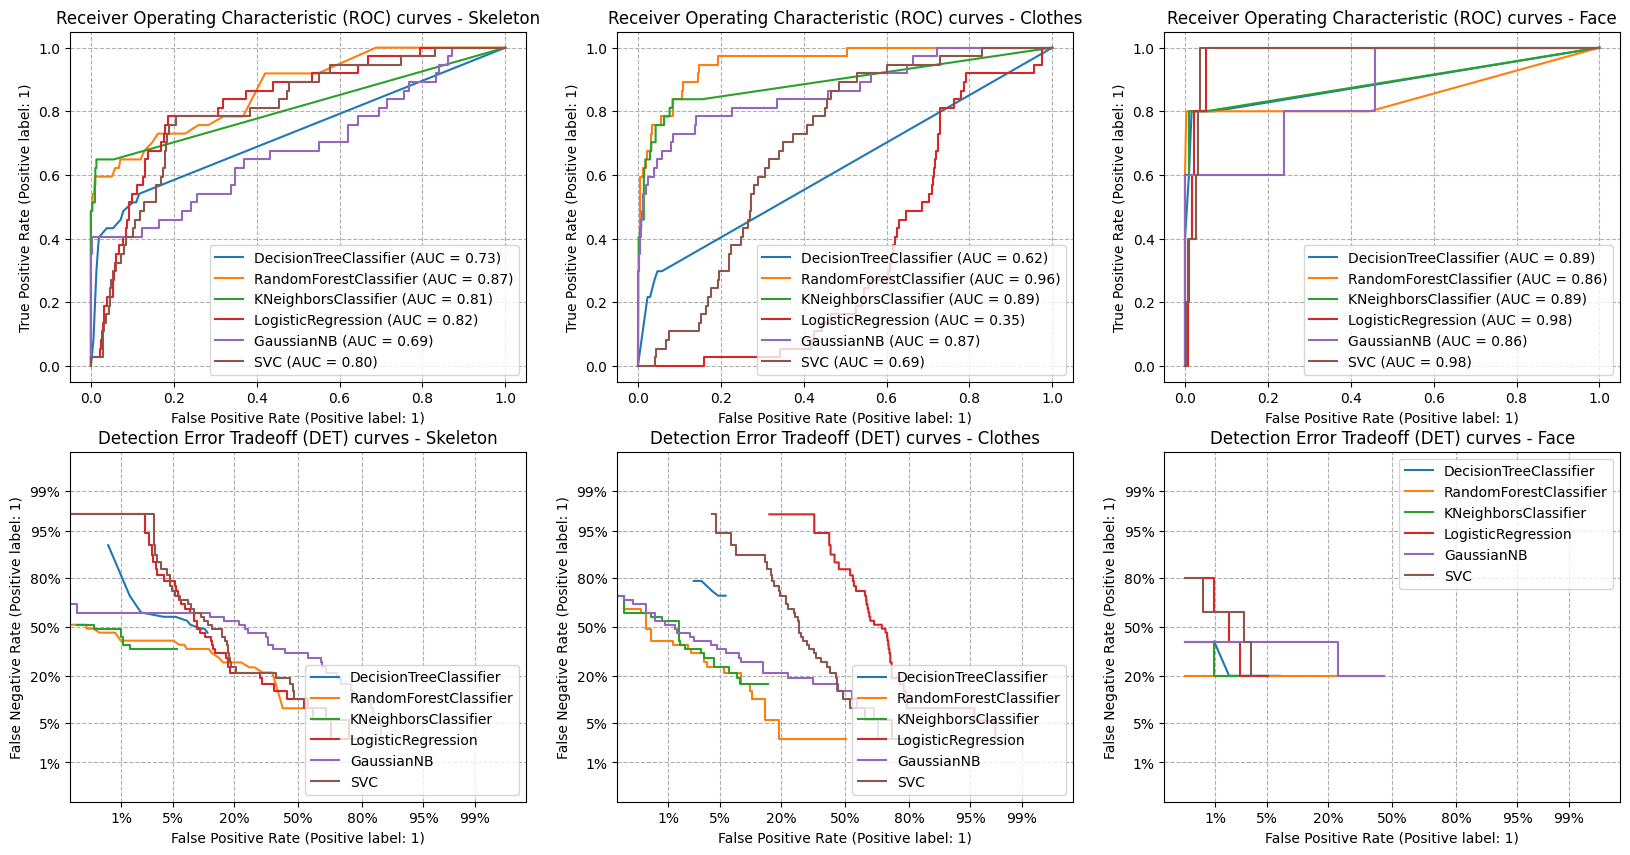

In [28]:

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

classifiers_skel = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=3, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_clothes = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, random_state=2, splitter='best'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 10, n_estimators = 100, random_state = 4),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=7, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

classifiers_face = {
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=2, splitter='random'),
    "RandomForestClassifier": RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50, random_state = 42),
    "KNeighborsClassifier": KNeighborsClassifier(algorithm='auto', leaf_size=10, n_neighbors=9, p=1, weights='distance'),
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=10000),
    "GaussianNB": GaussianNB(var_smoothing=1e-09),
    "SVC": SVC(C = 1, kernel = "linear", degree = 3, gamma = "auto", probability = True, tol = 0.001, random_state = 42),
}

fig, ((ax_roc_skel, ax_roc_clothes, ax_roc_face), (ax_det_skel, ax_det_clothes, ax_det_face)) = plt.subplots(2, 3, figsize =(20, 10))
# fig, (ax_roc_skel, ax_roc_clothes, ax_roc_face, ax_det_skel, ax_det_clothes, ax_det_face) = plt.subplots(1, 6, figsize=(50,5))

for name, model in classifiers_skel.items():
    model.fit(X_skel, y_train)
    RocCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_roc_skel, name=name)
    DetCurveDisplay.from_estimator(model, X_skel_test, y_test, ax=ax_det_skel, name=name)

for name, model in classifiers_clothes.items():
    model.fit(X_clothes, y_train)
    RocCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_roc_clothes, name=name)
    DetCurveDisplay.from_estimator(model, X_clothes_test, y_test, ax=ax_det_clothes, name=name)

for name, model in classifiers_face.items():
    model.fit(X_face, y_face)
    RocCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_roc_face, name=name)
    DetCurveDisplay.from_estimator(model, X_face_test, y_face_test, ax=ax_det_face, name=name)


ax_roc_skel.set_title("Receiver Operating Characteristic (ROC) curves - Skeleton")
ax_det_skel.set_title("Detection Error Tradeoff (DET) curves - Skeleton")
ax_roc_clothes.set_title("Receiver Operating Characteristic (ROC) curves - Clothes")
ax_det_clothes.set_title("Detection Error Tradeoff (DET) curves - Clothes")
ax_roc_face.set_title("Receiver Operating Characteristic (ROC) curves - Face")
ax_det_face.set_title("Detection Error Tradeoff (DET) curves - Face")


ax_roc_skel.grid(linestyle="--")
ax_det_skel.grid(linestyle="--")
ax_roc_clothes.grid(linestyle="--")
ax_det_clothes.grid(linestyle="--")
ax_roc_face.grid(linestyle="--")
ax_det_face.grid(linestyle="--")


plt.legend()
plt.savefig("ROC_DET_curves.png")

## Model Tuning

### Fit and Evaluate Models

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV


class_names = ['Different', 'Same']

def fit_models(models, X_train, y_train):
    for name, model in models.items():
        model.fit(X_train, y_train.ravel())
        print(name, 'trained.')
    return

def evaluate_models(models,model_name,X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred,zero_division=0))
        cv_accuracy = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='accuracy')
        cv_f1_macro = cross_val_score(model, X_test, y_test.ravel(), n_jobs=-1, scoring='f1_macro')
        print(cross_val_score(model, X_test, y_test, scoring='accuracy'))
        print("Accuracy: %0.4f (+/- %0.4f)" % (cv_accuracy.mean(), cv_accuracy.std() * 2))
        print(cross_val_score(model, X_test, y_test, scoring='f1_macro'))
        print("f1-score: %0.4f (+/- %0.4f)" % (cv_f1_macro.mean(), cv_f1_macro.std() * 2))
        if name.count("accuracy")> 0:
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
            disp.plot(cmap=plt.cm.Blues)
            disp.ax_.set_title(name + ' (' + model_name + ')') 
        print('------------------------------------'*3)
    return  

### Model Tuning

In [ ]:

def tune_model(model, param_grid, scoring, x_train, y_train, grid_jobs):
    print('tuning...')
    clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, verbose=1, n_jobs=grid_jobs)
    clf.fit(x_train, y_train.ravel())
    print('done')
    print()
    print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
    best_params = clf.best_params_.copy()
    return best_params

### Models

In [ ]:

SVM_param_grid = {
    'C': [0.5, 1],
    'kernel': ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [1,2,3,4,5],
    'gamma': ['scale'],
    'random_state': [2,42]
}

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}


Gauss_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

KNN_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

DT_param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'random_state': [2,42]
}

Regres_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.5, 1],
    'fit_intercept': [True, False],
    'intercept_scaling': [1, 2, 3],
    'class_weight': [None, 'balanced'],
    'random_state': [2,42],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'verbose': [0],
    'warm_start': [True, False],
    'n_jobs': [-1],
    'l1_ratio': [None]
}

models = {
    "KNN": (KNeighborsClassifier, KNN_param_grid),
    "DT": (DecisionTreeClassifier, DT_param_grid),
    "RF": (RandomForestClassifier, RF_param_grid),
    "GNB": (GaussianNB, Gauss_param_grid),
    "SVM": (SVC, SVM_param_grid),
    # "LogReg": (LogisticRegression(), Regres_param_grid),
}

### Tuning and Evaluation

In [ ]:

for model in models:
    print(model)
    current_model = models[model]
    best_accuracy_params_skel = tune_model(current_model[0](), current_model[1], 'accuracy', X_skel, y_train, -1)
    best_f1macro_params_skel = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_skel, y_train, -1)
    best_accuracy_params_clothes = tune_model(current_model[0](), current_model[1], 'accuracy', X_clothes, y_train, -1)
    best_f1macro_params_clothes = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_clothes, y_train, -1)
    best_accuracy_params_face = tune_model(current_model[0](), current_model[1], 'accuracy', X_face, y_face, -1)
    best_f1macro_params_face = tune_model(current_model[0](), current_model[1], 'f1_macro',  X_face, y_face, -1)
    tuned_models_skel = {
        'Skeleton accuracy': current_model[0](**best_accuracy_params_skel),
        'Skeleton f1_macro': current_model[0](**best_f1macro_params_skel)
    }

    tuned_models_clothes = {
        'Clothes accuracy': current_model[0](**best_accuracy_params_clothes),
        'Clothes f1_macro': current_model[0](**best_f1macro_params_clothes)
    }

    tuned_models_face = {
        'Face accuracy': current_model[0](**best_accuracy_params_face),
        'Face f1_macro': current_model[0](**best_f1macro_params_face)
    }
        
    fit_models(tuned_models_skel, X_skel, y_train)
    fit_models(tuned_models_clothes, X_clothes, y_train)
    fit_models(tuned_models_face, X_face, y_face)
    print("-"*50)
    print("Skeleton")
    evaluate_models(tuned_models_skel,model, X_skel, y_train)
    print("-"*50)
    print("Clothes")
    print("-"*50)
    evaluate_models(tuned_models_clothes,model, X_clothes, y_train)
    print("-"*50)
    print("Face")
    print("-"*50)
    evaluate_models(tuned_models_face,model, X_face, y_face)


### Results
| Model | Skeleton | Clothes | Face | 
| :--- | :---: | :---: | :---: | 
| DT | 0.91 | 0.93  | 0.81 |
| RF | 0.93 | 0.94  | 0.85 |
| SVC | 0.91 | 0.93  | 0.81 |
| GNB | 0.89 | 0.79  | 0.81 |
| KNN | 0.94 | 0.94  | 0.84 |

1 /media/andrea/NVMe/Dataset/ReID/Training/007/007_000204-a_9724007_rgb.jpg
2 /media/andrea/NVMe/Dataset/ReID/Training/007/007_000125-a_9715923_rgb.jpg
3 /media/andrea/NVMe/Dataset/ReID/Training/007/007_000389-a_9740922_rgb.jpg
4 /media/andrea/NVMe/Dataset/ReID/Training/007/007_000206-a_9724175_rgb.jpg
5 /media/andrea/NVMe/Dataset/ReID/Training/007/007_000202-a_9723839_rgb.jpg
6 /media/andrea/NVMe/Dataset/ReID/Training/006/006_000163-a_9663176_rgb.jpg
7 /media/andrea/NVMe/Dataset/ReID/Training/006/006_000111-a_9657844_rgb.jpg
8 /media/andrea/NVMe/Dataset/ReID/Training/006/006_000156-a_9662512_rgb.jpg
9 /media/andrea/NVMe/Dataset/ReID/Training/006/006_000199-a_9666928_rgb.jpg
10 /media/andrea/NVMe/Dataset/ReID/Training/037/037_000069-a_16668561_rgb.jpg
11 /media/andrea/NVMe/Dataset/ReID/Training/002/002_000040-a_8769745_rgb.jpg
12 /media/andrea/NVMe/Dataset/ReID/Training/005/005_000354-a_9442109_rgb.jpg
13 /media/andrea/NVMe/Dataset/ReID/Training/038/038_000067-a_16574067_rgb.jpg
14 /me

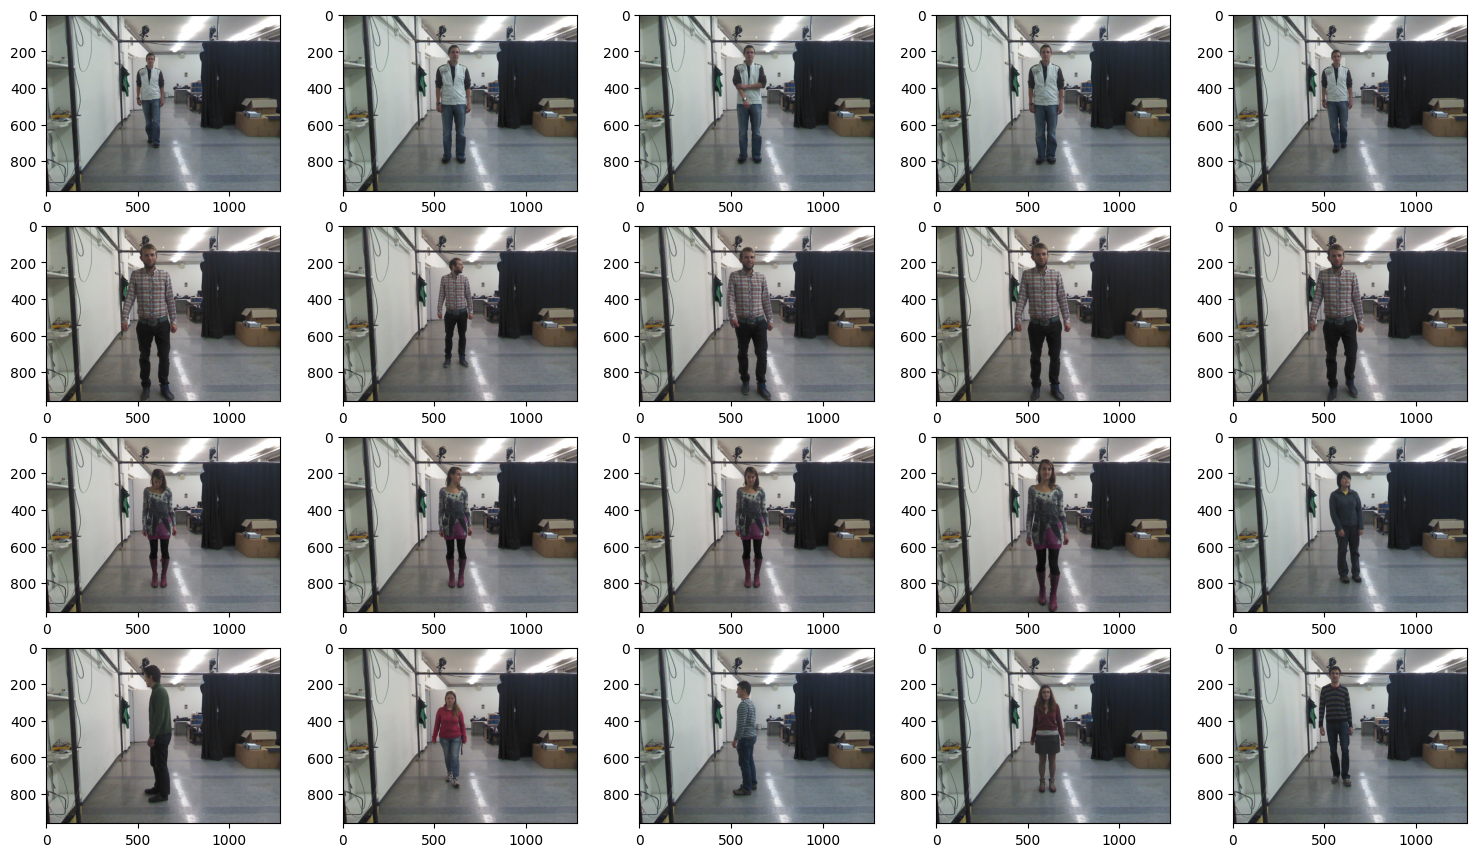

1 0


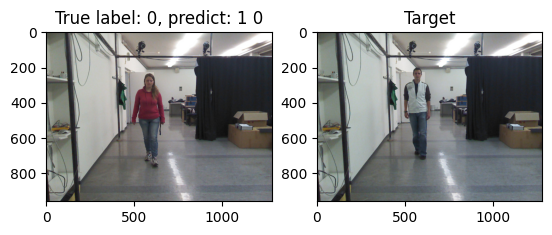

0 0


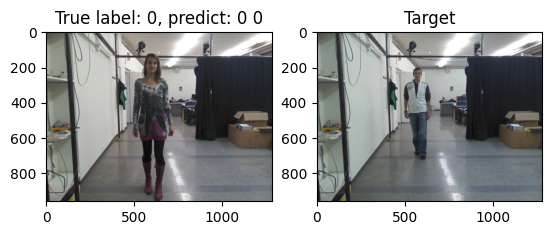

1 1


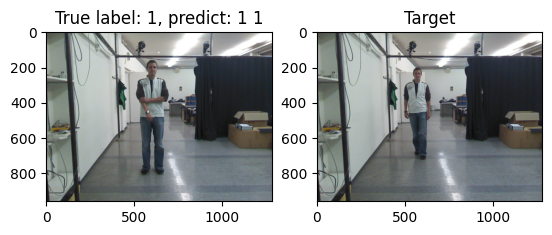

0 1


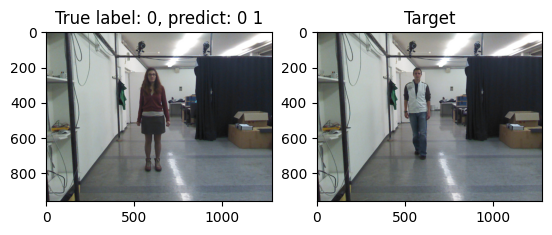

1 0


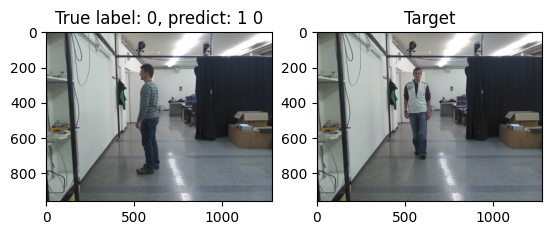

In [18]:
X, y, images = d.sample_dataset(return_images=True)

# X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

X_skel = X[:, : 9]
X_clothes = X[:, 9 : 9 + config.NUM_POINTS_LBP]
X_skel_train, X_skel_test, X_clothes_train, X_clothes_test, y_train, y_test, train_imgs, test_imgs= train_test_split(X_skel, X_clothes, y, images, stratify=y)

model_skel = RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, random_state = 42)
model_clothes = RandomForestClassifier(criterion ='entropy', max_depth = None, max_features ='sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = 42)
# model_face = SVC(C = 1, kernel = "poly", degree = 3, gamma = "auto", probability = True, random_state = 2)

model_skel.fit(X_skel_train, y_train)
model_clothes.fit(X_clothes_train, y_train)

skel_pred = model_skel.predict(X_skel_test)
print(classification_report(y_test, skel_pred))
print("-" * 10)
clothes_pred = model_clothes.predict(X_clothes_test)
print(classification_report(y_test, clothes_pred))
print("-" * 10)
# face_pred = model_face.predict(X_face_test)
# print(classification_report(y_face_test, face_pred))



target = np.where(y == 1)
target_img = images[target[0][0]]

fig, ax = plt.subplots(len(images) // 5, 5)
fig.set_size_inches(18.5, 10.5)

for i in range(len(y)):
    t, el = y[i], images[i]
    ax[i // 5, i % 5].imshow(el)
plt.show()
 

for idx in range(len(y_test)):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(test_imgs[idx])
    ax[0].set_title(f"True label: {y_test[idx]}, predict: {skel_pred[idx]} {clothes_pred[idx]}")
    ax[1].imshow(target_img)
    ax[1].set_title("Target")#"skel label: " + str(bool(res[1][0])), "clothes label: " + str(bool(res[1][1])), "face label: " + str(bool(res[1][2])))
    print(skel_pred[idx], clothes_pred[idx])
    plt.show()

## Regression

We also thought that it was possible to learn a "latent space" that ensambles that person's features. The idea is that a regressor can learn how to optimize the outpot of a linear combination so that features from the person that we want to re-identify will output a low value (0) while the other people will output an higher value (1).

Given that, we tested some regressors in order to learn the features of a person.

In [ ]:
# X_logistic, y_logistc, _ = d.sample_dataset(video=0, return_images=False)
X = np.load(config.SAMPLED_PATH + "video_0_sample_0_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_0_y.npy") * 100
X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test = filter_and_split_dataset(X, y)

X = np.load(config.SAMPLED_PATH + "video_0_sample_1_X.npy")
y = np.load(config.SAMPLED_PATH + "video_0_sample_1_y.npy") * 100
X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic = filter_and_split_dataset(X, y)
c_svr = 0

def test_regression(name, model_skel, model_clothes, model_face, 
        X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test,
        X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic):
    
    model_skel.fit(X_skel, y_train)
    model_clothes.fit(X_clothes, y_train)
    model_face.fit(X_face, y_face)

    # Train the logistic regressor
    log_reg_skel, log_reg_clothes, log_reg_face = LogisticRegression(max_iter = 10000), LogisticRegression(max_iter = 10000), LogisticRegression(max_iter = 10000)

    log_reg_skel.fit(model_skel.predict(X_skel_logistic).reshape(-1, 1), y_train_logistic)
    log_reg_clothes.fit(model_clothes.predict(X_clothes_logistic).reshape(-1, 1), y_train_logistic)
    log_reg_face.fit(model_face.predict(X_face_logistic).reshape(-1, 1), y_face_logistic)

    # Test
    print("-" * 10)
    print("|", name, "|")
    print("-" * 10)
    print("| skel |")
    skel_pred = model_skel.predict(X_skel_test)

    for a, b in zip(skel_pred, y_test):
        print(a, b)

    log_skel_pred = log_reg_skel.predict(skel_pred.reshape(-1, 1))

    print(classification_report(y_test, log_skel_pred))
    print(mean_absolute_error(y_test, skel_pred))
    print(mean_squared_error(y_test, skel_pred))

    print("| clothes |")
    clotehs_pred = model_clothes.predict(X_clothes_test)
    for a, b in zip(clotehs_pred, y_test):
        print(a, b)

    log_clotehs_pred = log_reg_clothes.predict(clotehs_pred.reshape(-1, 1))

    print(classification_report(y_test, log_clotehs_pred))
    print(mean_absolute_error(y_test, clotehs_pred))
    print(mean_squared_error(y_test, clotehs_pred))

    print("| face |")
    face_pred = model_face.predict(X_face_test)
    for a, b in zip(face_pred, y_face_test):
        print(a, b)
    log_face_pred = log_reg_face.predict(face_pred.reshape(-1, 1))

    print(classification_report(y_face_test, log_face_pred))
    print(mean_absolute_error(y_face_test, face_pred))
    print(mean_squared_error(y_face_test, face_pred))

    plt.plot(y_test, clotehs_pred, 'o')
    plt.show()

    plt.plot(y_test, skel_pred, 'o')
    plt.show()

    plt.plot(y_face_test, face_pred, 'o')
    plt.show()

In [ ]:
m1 = Pipeline([("poly", PolynomialFeatures(degree=2)), ("LinReg", Lasso(max_iter=100000))])
m2 = Pipeline([("poly", PolynomialFeatures(degree=2)), ("LinReg", Lasso(max_iter=100000))])
m3 = Pipeline([("poly", PolynomialFeatures(degree=2)), ("LinReg", Lasso(max_iter=100000))])
test_regression("Pipeline", m1, m2, m3, X_skel, X_clothes, X_face, X_skel_test, X_clothes_test, X_face_test, y_train, y_test, y_face, y_face_test, X_skel_logistic, X_clothes_logistic, X_face_logistic, X_skel_test_logistic, X_clothes_test_logistic, X_face_test_logistic, y_train_logistic, y_test_logistic, y_face_logistic, y_face_test_logistic)

In [ ]:
m1 = Pipeline([("poly", PolynomialFeatures()), ("Regression", SVR())])
m2 = Pipeline([("poly", PolynomialFeatures()), ("Regression", SVR())])
m3 = Pipeline([("poly", PolynomialFeatures()), ("Regression", SVR())])

The first thing that we did was to read the dataset and extract the information that we need in order to recognize people:

Best paramatri